In [10]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [11]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.5
sim.parameters["n_variants"] = 20

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
@mr_sim.variable
def x_e_variance(sim):
    """Variance for the environmental component of the exposure."""
    target = 1 - sim.parameters["h2"] - sim.parameters["ux_effect"] ** 2
    if target < 0:
        raise ValueError("Unacheivable value.")
    return target
sim.add_sim_parameter(x_e_variance)

sim.parameters["y_e_std"] = 1

In [12]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
        0.2,
        0.4,
        size=sim.get_sim_parameter("n_variants")
        # equivalently: sim.parameters["n_variants"]
    )
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
variants = []
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    variants.append(variant)

sim.add_variables(variants)

# We simulate variant effects.
# Note that these effects will yield the desired heritability
# only if var(g) = 1 (i.e. if the variants have been scaled).
sim.add_sim_parameter(
    mr_sim.Normal(
        "gx_effects",
        mu=0,
        sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
        size=sim.parameters["n_variants"]
    )
)
    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        scaled_variant = (variant - np.mean(variant)) / np.std(variant)
        effect = variant_effects[i]
        
        x += effect * scaled_variant
        
    print("Var_G = {}".format(np.var(x)))
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(
        0,
        scale=np.sqrt(sim.parameters["x_e_variance"]),
        size=sim.n
    )
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

Var_G = 0.5173764538893671


In [13]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)
!ls

Var_G = 0.5327101466429207
basic_simulation_model.ipynb
bin_iv_varying_h2
mr_simulation_0_simulation_data.csv.gz
mr_simulation_0_simulation_parameters.json
mr_simulation_1_simulation_data.csv.gz
mr_simulation_1_simulation_parameters.json
sim.pkl


In [14]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,0.454314,0,1,1,1,0,0,0,0,0,...,0,1,0,1,1,1,0,0,-1.127089,-1.302141
1,0.039578,1,0,1,0,1,0,2,1,0,...,1,1,0,0,0,0,0,2,1.497884,0.094465
2,-2.034643,1,1,0,0,0,0,1,1,1,...,0,1,0,1,1,0,0,0,-1.163052,1.676707
3,1.359632,0,1,1,0,0,2,0,0,1,...,1,1,0,2,0,1,1,1,-0.451333,-1.371556
4,-1.543874,0,0,1,0,1,1,0,2,0,...,1,0,0,0,0,0,1,0,-1.552984,1.709519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.014501,0,1,1,1,2,1,0,0,2,...,0,1,0,0,1,1,0,0,-1.367547,-1.612522
99996,-1.010672,1,0,2,0,0,1,0,1,2,...,0,0,1,0,1,0,1,0,-1.252435,-1.125223
99997,0.096267,0,0,1,1,0,0,0,0,0,...,0,1,0,1,0,1,1,0,-0.122967,-1.852121
99998,-1.632086,0,0,1,0,0,0,2,0,0,...,2,1,1,2,1,0,1,1,0.330918,1.638197


In [15]:
# Check how close we are to the desired heritability.
res = sm.OLS(
    sim.get_variable_data("exposure"),
    sm.add_constant(  # Adds intercept
        sim._data[[f"v{i+1}" for i in range(15)]]
    )
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               exposure   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     5007.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:43:13   Log-Likelihood:            -1.1553e+05
No. Observations:              100000   AIC:                         2.311e+05
Df Residuals:                   99984   BIC:                         2.312e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5877      0.009    -63.370      0.000      -0.606      -0.570
v1             0.0633      0.004     15.923      0.000       0.055       0.071
v2            -0.2867      0.004    -81.024      0.000      -0.294      -0.280
v3            -0.0891      0.004    -25.414      0.000      -0.096      -0.082
v4             0.5172      0.004    132.823      0.000       0.510       0.525
v5            -0.0390      0.004    -10.650      0.000      -0.046      -0.032
v6            -0.0174      0.004     -4.334      0.000      -0.025      -0.010
v7             0.3324      0.004     91.432      0.000       0.325       0.340
v8            -0.4111      0.004    -97.695      0.000      -0.419      -0.403
v9             0.1113      0.004     31.300      0.000       0.104       0.118
v10           -0.1460      0.004    -36.537      0.000      -0.154      -0.138
v11           -0.0145      0.004     -4.099      0.000      -0.021      -0.008
v12            0.2462      0.004     69.569      0.000       0.239       0.253
v13            0.6046      0.004    152.576      0.000       0.597       0.612
v14           -0.0158      0.004     -4.341      0.000      -0.023      -0.009
v15            0.1536      0.004     37.028      0.000       0.145       0.162
==============================================================================
Omnibus:                        7.059   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.070
Skew:                          -0.020   Prob(JB):                       0.0292
Kurtosis:                       2.989   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

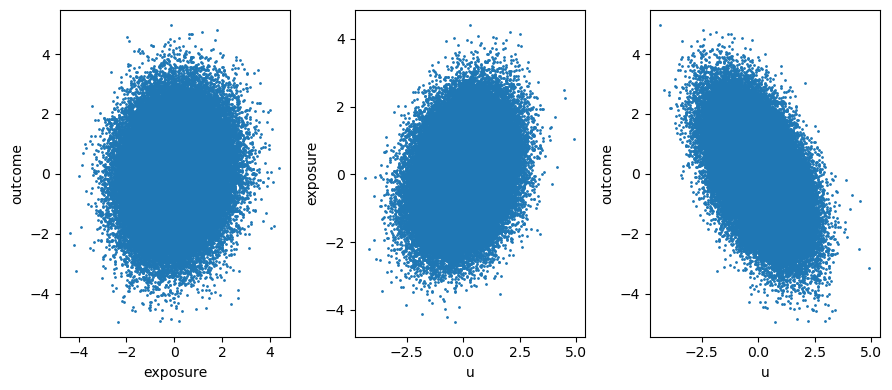

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [17]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,0.454314,0,1,1,1,0,0,0,0,0,...,0,1,0,1,1,1,0,0,-1.127089,-1.302141
1,0.039578,1,0,1,0,1,0,2,1,0,...,1,1,0,0,0,0,0,2,1.497884,0.094465
2,-2.034643,1,1,0,0,0,0,1,1,1,...,0,1,0,1,1,0,0,0,-1.163052,1.676707
3,1.359632,0,1,1,0,0,2,0,0,1,...,1,1,0,2,0,1,1,1,-0.451333,-1.371556
4,-1.543874,0,0,1,0,1,1,0,2,0,...,1,0,0,0,0,0,1,0,-1.552984,1.709519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.014501,0,1,1,1,2,1,0,0,2,...,0,1,0,0,1,1,0,0,-1.367547,-1.612522
99996,-1.010672,1,0,2,0,0,1,0,1,2,...,0,0,1,0,1,0,1,0,-1.252435,-1.125223
99997,0.096267,0,0,1,1,0,0,0,0,0,...,0,1,0,1,0,1,1,0,-0.122967,-1.852121
99998,-1.632086,0,0,1,0,0,0,2,0,0,...,2,1,1,2,1,0,1,1,0.330918,1.638197


In [18]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

Var_G = 0.3263536625628095


,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,0.603315,0,1,0,0,1,1,1,0,0,...,1,1,1,1,0,0,0,0,0.664431,-0.816070
1,0.003592,1,1,0,0,0,0,1,1,2,...,0,1,1,0,1,2,0,2,0.105337,-0.261546
2,1.853810,1,1,2,0,0,0,1,0,1,...,1,2,1,0,0,0,0,0,-0.673668,-1.847872
3,-0.364332,0,1,1,1,0,0,0,0,1,...,2,0,2,0,0,1,0,1,0.147365,0.401576
4,-0.025493,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,-0.564892,-0.415077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.269935,0,2,2,0,2,0,1,1,1,...,0,0,0,1,0,0,0,1,-0.760523,-1.544581
99996,1.148256,1,1,2,0,1,0,0,0,1,...,0,0,1,1,1,2,1,0,-0.641055,0.905003
99997,-1.717804,0,1,0,0,2,1,0,1,1,...,0,1,0,0,1,0,1,1,-1.063487,0.443362
99998,0.084022,1,2,0,0,1,1,1,0,1,...,0,2,0,0,0,0,0,0,0.699985,0.335113
